# Imaging Lab 2: Single Pixel Scanning

### EECS 16A: Designing Information Devices and Systems I, Spring 2016

**Name 1**: Collin Chin

**Login**: ee16a-ait


**Name 2**:

**Login**: ee16a-


## Table of Contents

* Setup
    * [Light Sensor](#task1a)
    * [MSP430 Code](#task1b)
    * [Projector](#task1c)
* Images and Arrays
    * [Images](#task2a)
    * [Scanning Matrix](#task2b)
* [Real Image Scanning](#task3)

# Overview
This week, you will scan an image pixel by pixel and write code to recreate it with the sensor readings. Specifically, you will begin by checking that the circuit you built last time still works and that the projector is correctly connected to the computer. Next, you will write code to generate the pattern that the projector will use to scan through the image. Finally, you will use your code and scanning matrix to  image a card!
<br/><br/>
<center>
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/proj_prof.png" style="height:256px" />
</center>

<a id='task1a'></a>
##<span style="color:blue">Task 1a: Light Sensor</span>

Build your solar cell circuit as you did in Imaging Lab 1:
<br/><br/>

<center>
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/SolarCell%20Circuit.png" align="center" style="height:200px" />
</center>

<a id='task1b'></a>
**<span style="color:red">Use the oscilloscope to confirm that the sensor you built last week still responds to changes in light. You should be able to reproduce the same output you saw before.</span>**

##<span style="color:blue">Task 1b: Upload Code to MSP430</span>
We will be using a different MSP430 program this week.<br/> 
**<span style="color:red"> Upload the `AnalogReadSerial` program to your MSP430. This is located in the lab folder you downloaded. To verify that the program is working, type a '6' into the serial monitor. You should see a reading from the solar cell appear.</span>**

<a id='task1c'></a>
##<span style="color:blue">Task 1c: Projector Setup</span>
* Place the breadboard, MSP430, and solar cell in the stand.
* Connect the USB cable to the MSP430.
* Connect the HDMI and power cables to the projector.
* Turn on the projector (using the power button on the top) and use the left/right arrows to select the HDMI output.
* <span style="color:blue">The projector, 3D printed stand, and MSP430 should all be placed inside the box!</span>

**<span style="color:red">Confirm that you are able to see a blank Windows Desktop on the projector screen.</span>**


In [2]:
#Import Necessary Libraries
from  pylab import *
import struct
import numpy as np
import time
import scipy
from scipy import linalg
import serial
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<a id='task2a'></a>
##<span style="color:blue">Task 2a: Working with Images</span>
A simple grayscale image can be represented using a 2D numpy array. The values stored in this array correspond to different shades of gray, where lower numbers are darker and higher numbers are lighter.  

To see how this works, create a 5x5 numpy array with linearly spaced floating point values from 0 to 1. i.e. gradient_image[0,0] = 0.0, gradient_image[2,2] = 0.5, and gradient_image[4,4] = 1.0

<br/>


**<span style="color:red">Create the gradient 5x5 array here. It should look like the following:</span>**


<br/>
<center>
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/gradient.JPG" align="center" style="height:200px" />
</center>

In [3]:
# TODO: Make a gradient image from 0 to 1

gradient_image = np.linspace(0, 1, 25).reshape(5,5)

print(gradient_image)

[[ 0.          0.04166667  0.08333333  0.125       0.16666667]
 [ 0.20833333  0.25        0.29166667  0.33333333  0.375     ]
 [ 0.41666667  0.45833333  0.5         0.54166667  0.58333333]
 [ 0.625       0.66666667  0.70833333  0.75        0.79166667]
 [ 0.83333333  0.875       0.91666667  0.95833333  1.        ]]


**<span style="color:red">Display the same matrix with `plt.imshow`.</span>**

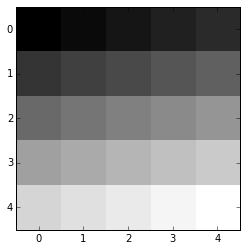

In [4]:
plt.imshow(gradient_image, cmap='gray', interpolation='nearest')

**<span style="color:red">What do you notice about the relationship between how numbers between 0 to 1 relate to grayscale colors? What color would 1 correspond to? What about 0?</span>**

ADD COMMENTS HERE

<a id='task2b'></a>
##<span style="color:blue">Task 2b: Scanning Matrix</span>

Next, we will create an array that we will use to illuminate individual pixels for our single pixel camera. The first step is to think about the image as a vector (you will see why this is important soon).

**<span style="color:red">
Convert the `gradient_image` that you created above into a 1x25 (row) vector and display it. You will find the command `np.reshape` helpful. What do you notice? </span>**

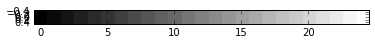

In [5]:
##TODO: Convert matrix to vector

gradient_image_vector = gradient_image.reshape(1,25)

##Display the vector
plt.imshow(gradient_image_vector, cmap='gray', interpolation='nearest')

##Imaging Mask
Our goal is to scan an image with the single pixel camera, take the output from the camera (a vector), and turn it back into the original image (an array).

Let's suppose the original image we scanned with our single pixel camera was `gradient_image` and that the output from the camera was `gradient_image_vector`.  

What matrix multiplied with `gradient_image_vector` will return `gradient_image_vector`? Your answer should be a simple matrix, which we will call $H$.
This operation is represented in the following equation:

 $$\vec{i} * H = \vec{s}$$ where $H$ is the imaging mask, $i$ is the image vector, and $s$ is the sensor reading vector. In this case, $H$ is selected so that $\vec{i}$ and $\vec{s}$ are equal. This will not always be the case. 

**<span style="color:red">
Create the imaging mask $H$. What dimensions does it have and why? </span>**

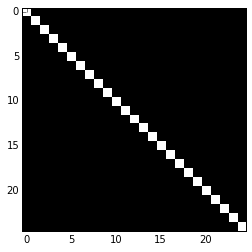

In [6]:
##TODO: Create the multiplication matrix
H = np.identity(25)

#Display this image mask
plt.imshow(H, cmap='gray', interpolation='nearest')

**<span style="color:red">
Multiply the $H$ matrix with `gradient_image_vector` to get the same vector back! Remember to use `np.dot` to do matrix multiplication.</span>**

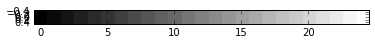

In [7]:
##TODO: Recreate the gradient_image_vector by multiplying H and gradient_image_vector
gradient_image_recreate = np.dot(gradient_image_vector, H)

##Display the result and compare to gradient_image_vector
plt.imshow(gradient_image_recreate, cmap='gray', interpolation='nearest')

What is happening in this matrix multiplication? Each column of matrix H is responsible for "illuminating", or selecting, a single pixel in the gradient image!

For the `gradient_image_vector`, we created it by converting the 5x5 image into a vector. Similarly, *every* column in the matrix H can be represented as a 5x5 image. 

**<span style="color:red">
To see this, iterate through each column of matrix H, reshape it into a 5x5 image, and check that each column illuminates a unique pixel of the original 5x5 image! Based on the equation, why should it be the columns?</span>**

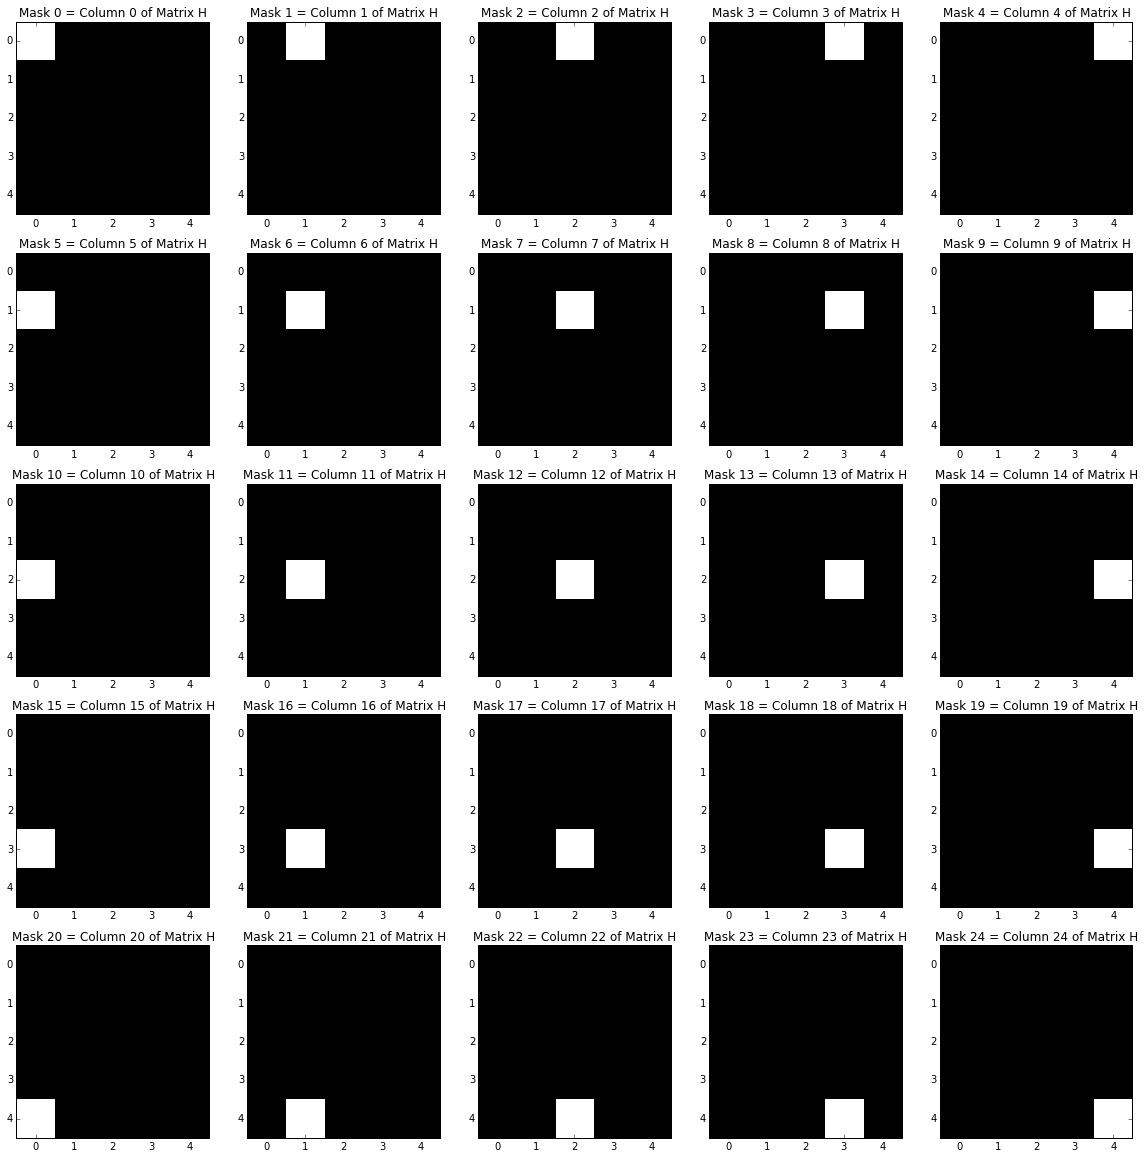

In [8]:
##TODO: Iterate through columns of matrix H and form individual masks
figure(figsize=(20,20))
for j in range(0,25):
    subplot(5,5,j+1)
    
    proj = H[:,j].reshape(5,5)
        
    
    imshow(proj,cmap='gray', interpolation='nearest');
    title('Mask ' + str(j) + ' = Column ' + str(j) + ' of Matrix H')

Each of these images that we've created are called masks. The white pixels are transparent and the black pixels are not. When we project one of these masks over our image, we shine only one pixel of light at a time. We can gather information about just that pixel in the image.

Let's try an imaging mask that's a bit more complicated. Say we want our sensor reading vector to contain the values for every other pixel (0,2,4...), followed by the pixels we skipped (1,3,5...). 

**<span style="color:red">
Repeat the above procedure with a new imaging mask, $H1$ that selects alternate pixels. </span>**
Hint: Try to use columns from the existing H matrix. Review the Python tutorial. Also, look up the numpy concatenate function.

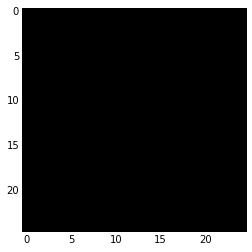

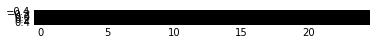

In [10]:
import math

H1 = np.zeros((25,25))
for i in range(0,13):
    H1[:,j/2] = H1[:,j]
for i in range(13, 24):
    H1[:,(j/2)] = H1[:,j]
#Display this image mask
figure()
plt.imshow(H1, cmap='gray', interpolation='nearest')

##TODO: Recreate the gradient_image_vector by multiplying gradient_image_recreate1 and H1
gradient_image_recreate1 = np.dot(gradient_image_recreate, H1 )


#Display the result and compare to gradient_image_vector
figure()
plt.imshow(gradient_image_recreate1, cmap='gray', interpolation='nearest')

<a id='task3'></a>
##<span style="color:blue">Task 3: Imaging Real Pictures</span>

Finally, we will use our two matrices to image a real picture. Because our picture is fairly large, we want each individual mask to have dimensions 40x30 to match the 4:3 aspect ratio of the projector. To do so, 
**<span style="color:red">
recreate both the $H$ and $H1$ masks to match these dimensions. </span>**



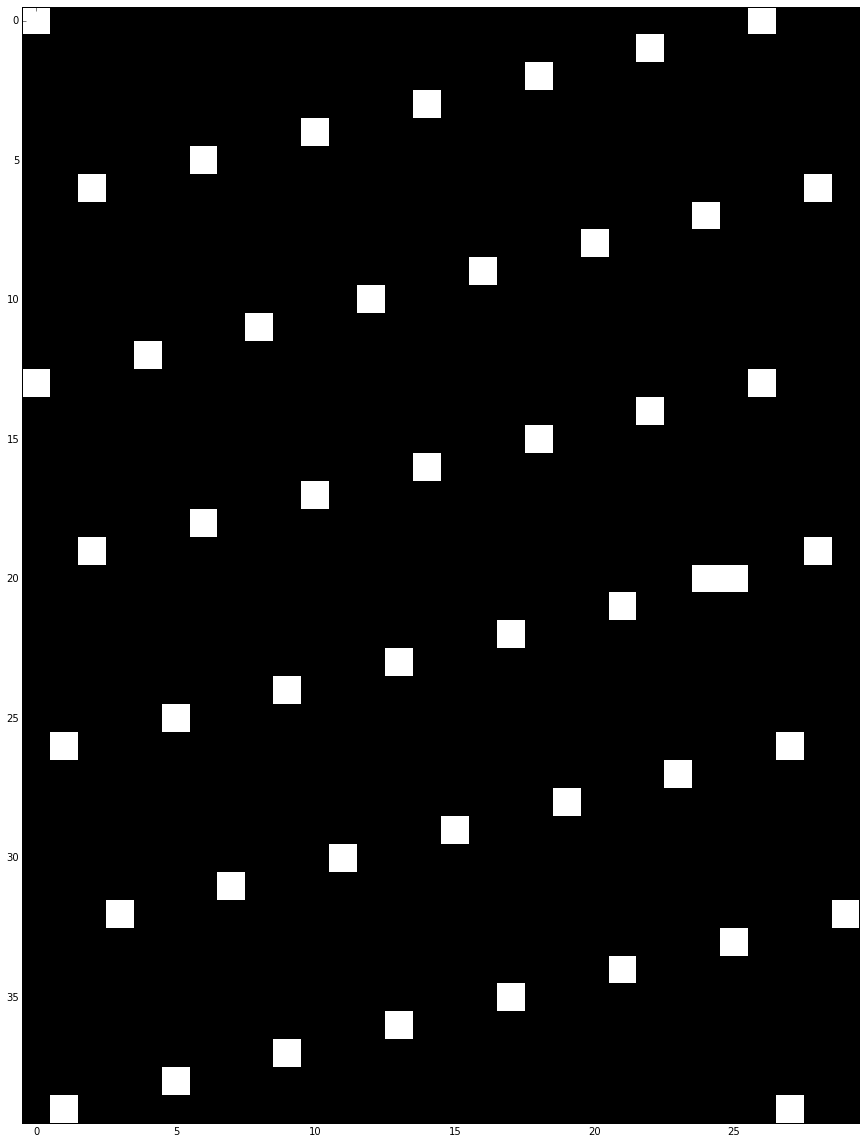

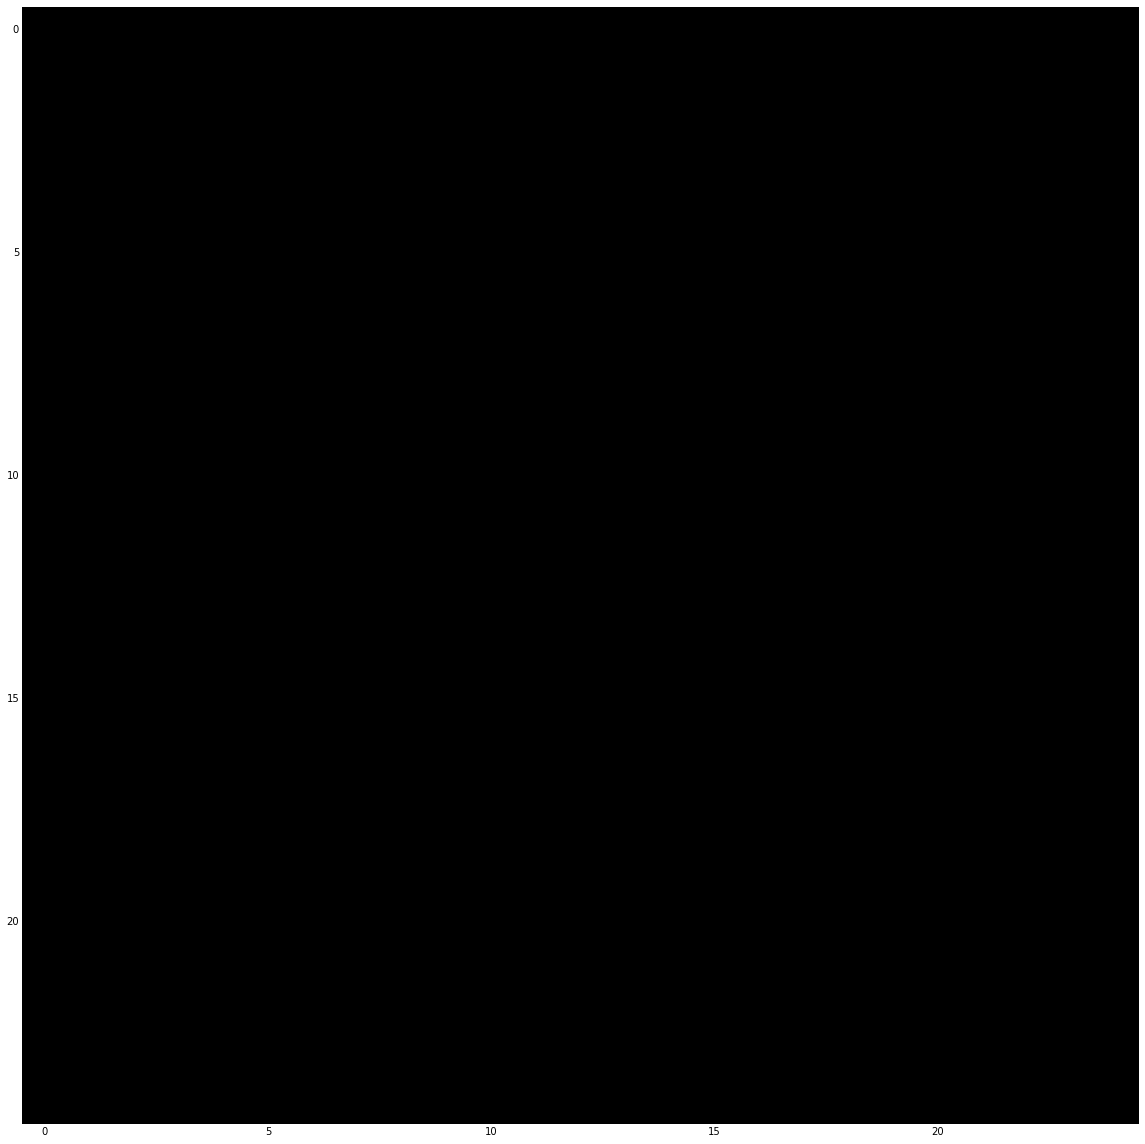

In [14]:
##TODO: Recreate H
H = np.resize(np.identity(25),(40,30))
figure()
figure(figsize=(20,20))
plt.imshow(H, cmap='gray', interpolation='nearest')

##TODO: Recreate H1      
H1 = np.resize(/*use orig H1*/, (40,30))
figure(figsize=(20,20))
plt.imshow(H1, cmap='gray', interpolation='nearest')

In order to tell the imaging code to use a specific matrix, we save it into a variable called `imaging_mask`. 

In [ ]:
np.save('imaging_mask.npy',H)

Open a new command line window. From the command line (in the lab project directory), run

`python capture_image.py`

The script projects patterns based on the masks you designed, `imaging_mask.npy`. The sensor readings will then be saved into an array named `sensor_readings.npy`.

When running the command in the terminal, you will be prompted for the com port and the display. 

Select the UART COM port (can be found using the Device Manager) and the 1280x720 projector screen. 

You are given the option to add a delay to your scan. This delay has units of milliseconds and can be positive, negative or 0. With a delay of 0, each pixel will take 100ms scan. Feel free to tweak this delay to improve your images. A longer (more positive) delay might lead to better quality images by giving the filter more time to settle. Finally, a window will pop up and you can begin your scan. 


**<span style="color:red">
To begin the scan, you will need to click on the Python window that popped up in the task bar, and then press 'Enter.' </span>** This selects the projector screen and runs the scan. **Make sure your box is fully closed when scanning.**

After the sensor readings have been captured, load the sensor reading vector. Here is the equation relating H, sensor readings, and image vector:

$$\vec{i} * H = \vec{s}$$

**<span style="color:red">
Recreate the image vector from the sensor readings. 
</span>**



In [ ]:
%pylab inline

In [ ]:
#WARNING!! If you run multiple scans (by pressing enter at the end of a scan) the sensor_readings0.npy file 
#  will incrememnt to sensor_readings1.npy, sensor_readings2.npy etc Make sure you read in the correct file. 

sr = np.load('data/sensor_readings0.npy') #what are the dimensions?

#TODO: Create the image vector from H and sr
#Hint: Because H is a special matrix, technically you do not need to perform any matrix operations
iv = sr


#Contrast code
m = median(iv)
s = std(iv)

if s< 20:
    s = 20

#Display the result
plt.figure(figsize=(3,4))
plt.imshow(np.reshape(iv,(30,40)), cmap='gray', vmin = m - s, vmax = m + s, interpolation='nearest')

Congratulations! You have imaged your first image using your single pixel camera! 


**<span style="color:red">
Does your recreated image match the real image? What are some problems you notice? 
</span>**


Here are some example images that we recreated using this setup:
![Figure 1-1](http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/figure_1.png "The Ace of Spades!!")
![Figure 1-2](http://inst.eecs.berkeley.edu/~ee16a/images/imaging_img/trial_1.PNG "The 7 of Spades!!")

**<span style="color:red">
Next, use the second mask for imaging. Can you repeat the same procedure by just replacing $H$ with $H1$? Why or why not?</span>**

In [ ]:
np.save('imaging_mask.npy', H1)

Now run `capture_image.py` from the command line again (make sure to restart the script) to collect sensor readings, then reconstruct the image.

**<span style="color:red">
Note that it is very important to seal the imaging system inside the box to keep ambient light out</span>**

In [ ]:
#WARNING!! If you run multiple scans (by pressing enter at the end of a scan) the sensor_readings0.npy file 
#  will incrememnt to sensor_readings1.npy, sensor_readings2.npy etc Make sure you read in the correct file. 

sr = np.load('data/sensor_readings0.npy')

#TODO: Create the image vector from H1 and sr
#Hint: Here, H1 is not a special matrix so you will need to perform a matrix operation
#iv = np.dot(sr,np.linalg.inv(H))


#Contrast code
m = median(iv)
s = std(iv)
if s< 20:
    s = 20

#Display the result
plt.figure(figsize=(3,4))
plt.imshow(np.reshape(iv,(30,40)), cmap='gray', vmin = m - s, vmax = m + s, interpolation='nearest')

You are done for the week! Save your code and low pass filter circuit for next week, where you will illuminate multiple pixels per mask!

#### You are ready to sign up for checkoff. DO NOT disassembly your circuit before checking off. Afterwards, you may take the Launchpad and circuit kit with you. <span style="color:red"> DO NOT TAKE THE SOLAR CELL. LEAVE IT IN YOUR DESK BASKET. </span>